In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from os import path
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2021-07-08 23:40:10.118627: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Num GPUs Available:  1


2021-07-08 23:40:10.903207: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-08 23:40:10.945614: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-08 23:40:10.945858: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2070 SUPER computeCapability: 7.5
coreClock: 1.815GHz coreCount: 40 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2021-07-08 23:40:10.945880: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-08 23:40:10.947859: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-07-08 23:40:10.947935: I tensorflow/stream_execut

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# constants
batch_size = 32
img_height = 180
img_width = 180
train_data_dir = path.join('data', 'large_set')
sample_seed = 123

In [4]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  train_data_dir,
  validation_split=0.2,
  subset="training",
  seed=sample_seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)
validate_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  train_data_dir,
  validation_split=0.2,
  subset="validation",
  seed=sample_seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)
class_names = train_dataset.class_names

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


2021-07-08 23:40:11.317588: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-07-08 23:40:11.318812: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-08 23:40:11.319052: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2070 SUPER computeCapability: 7.5
coreClock: 1.815GHz coreCount: 40 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2021-07-08 23:40:11.319105: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


2021-07-08 23:40:12.081846: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-08 23:40:12.101547: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3601000000 Hz


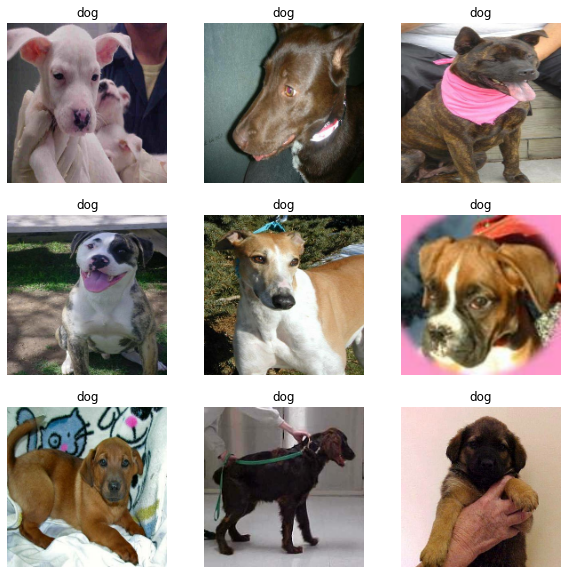

In [5]:
# sample some images and show
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_dataset.class_names[labels[i]])
    plt.axis("off")

In [6]:
# configure for performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validate_dataset = validate_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
num_classes = 5

# define the model
# augment images by adding noise
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)
# normalize image pixels into [0,1]
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
model = Sequential([
  data_augmentation,
  normalization_layer,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)       

In [8]:
# train and show training process
epochs = 50
history = model.fit(
  train_dataset,
  validation_data=validate_dataset,
  epochs=epochs
)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Epoch 1/50


2021-07-08 23:40:19.668737: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-07-08 23:40:20.147665: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2021-07-08 23:40:20.619903: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-07-08 23:40:21.143594: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


625/625 [==============================] - 19s 16ms/step - loss: 0.6221 - accuracy: 0.6559 - val_loss: 0.5524 - val_accuracy: 0.7190

KeyboardInterrupt: 

In [ ]:
def predict(input_file_path: str):
  img = keras.preprocessing.image.load_img(
    input_file_path, target_size=(img_height, img_width)
  )
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)  # Create a batch

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
      .format(class_names[np.argmax(score)], 100 * np.max(score))
  )

input_path = '/home/troublor/workspace/catsVSdogs/data/small_set/dog/24.jpg'
predict(input_path)

In [ ]:
# save trained model
save_path = path.join('model', 'classifier.h5')

model.save(save_path)